# Practical Statistics for Data Scientists (Python)
# Chapter 5. Classification
> (c) 2019 Peter C. Bruce, Andrew Bruce, Peter Gedeck

In [ ]:
!pip install pygam dmba

     |████████████████████████████████| 11.8 MB 6.4 MB/s 


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression #, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

import statsmodels.api as sm

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from pygam import LinearGAM, s, f, l


from dmba import classificationSummary

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

no display found. Using non-interactive Agg backend


In [ ]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [ ]:
LOAN3000_CSV = DATA / 'loan3000.csv'
LOAN_DATA_CSV = DATA / 'loan_data.csv.gz'
FULL_TRAIN_SET_CSV = DATA / 'full_train_set.csv.gz'

# Naive Bayes
## The Naive Solution

In [ ]:
loan_data = pd.read_csv(LOAN_DATA_CSV)

# convert to categorical
loan_data.outcome = loan_data.outcome.astype('category')
loan_data.outcome.cat.reorder_categories(['paid off', 'default'])
loan_data.purpose_ = loan_data.purpose_.astype('category')
loan_data.home_ = loan_data.home_.astype('category')
loan_data.emp_len_ = loan_data.emp_len_.astype('category')

predictors = ['purpose_', 'home_', 'emp_len_']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='')
y = loan_data[outcome]

naive_model = MultinomialNB(alpha=0.01, fit_prior=True)
naive_model = MultinomialNB(alpha=0, fit_prior=False)
naive_model.fit(X, y)

new_loan = X.loc[146:146, :]
print('predicted class: ', naive_model.predict(new_loan)[0])

probabilities = pd.DataFrame(naive_model.predict_proba(new_loan),
                             columns=naive_model.classes_)
print('predicted probabilities',)
print(probabilities)

predicted class:  default
predicted probabilities
    default  paid off
0  0.653699  0.346301


/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN


### Example not in book

Numerical variables are not supported in scikit-learn. The example would need to demonstrate binning a variable and display the probability distribution of the bins.
```
## example not in book
less_naive <- NaiveBayes(outcome ~ borrower_score + payment_inc_ratio + 
                           purpose_ + home_ + emp_len_, data = loan_data)
less_naive$table[1:2]

png(filename=file.path(PSDS_PATH, 'figures', 'psds_naive_bayes.png'),  width = 4, height=3, units='in', res=300)

stats <- less_naive$table[[1]]
ggplot(data.frame(borrower_score=c(0,1)), aes(borrower_score)) +
  stat_function(fun = dnorm, color='blue', linetype=1, 
                arg=list(mean=stats[1, 1], sd=stats[1, 2])) +
  stat_function(fun = dnorm, color='red', linetype=2, 
                arg=list(mean=stats[2, 1], sd=stats[2, 2])) +
  labs(y='probability')
dev.off()
```

# Discriminant Analysis
## A Simple Example

In [ ]:
loan3000 = pd.read_csv(LOAN3000_CSV)
loan3000.outcome = loan3000.outcome.astype('category')

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)
print(pd.DataFrame(loan_lda.scalings_, index=X.columns))

                          0
borrower_score     7.175839
payment_inc_ratio -0.099676


In [ ]:
pred = pd.DataFrame(loan_lda.predict_proba(loan3000[predictors]),
                    columns=loan_lda.classes_)
print(pred.head())

    default  paid off
0  0.553544  0.446456
1  0.558953  0.441047
2  0.272696  0.727304
3  0.506254  0.493746
4  0.609952  0.390048


### Figure 5.1

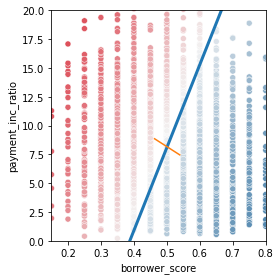

In [ ]:
# Use scalings and center of means to determine decision boundary
center = np.mean(loan_lda.means_, axis=0)
slope = - loan_lda.scalings_[0] / loan_lda.scalings_[1]
intercept = center[1] - center[0] * slope

# payment_inc_ratio for borrower_score of 0 and 20
x_0 = (0 - intercept) / slope
x_20 = (20 - intercept) / slope

lda_df = pd.concat([loan3000, pred['default']], axis=1)
lda_df.head()

fig, ax = plt.subplots(figsize=(4, 4))
g = sns.scatterplot(x='borrower_score', y='payment_inc_ratio',
                    hue='default', data=lda_df, 
                    palette=sns.diverging_palette(240, 10, n=9, as_cmap=True),
                    ax=ax, legend=False)

ax.set_ylim(0, 20)
ax.set_xlim(0.15, 0.8)
ax.plot((x_0, x_20), (0, 20), linewidth=3)
ax.plot(*loan_lda.means_.transpose())

plt.tight_layout()
plt.show()

# Logistic regression
## Logistic Response Function and Logit

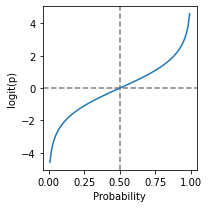

In [ ]:
p = np.arange(0.01, 1, 0.01)
df = pd.DataFrame({
    'p': p,
    'logit': np.log(p / (1 - p)),
    'odds': p / (1 - p),
})

fig, ax = plt.subplots(figsize=(3, 3))
ax.axhline(0, color='grey', linestyle='--')
ax.axvline(0.5, color='grey', linestyle='--')
ax.plot(df['p'], df['logit'])
ax.set_xlabel('Probability')
ax.set_ylabel('logit(p)')

plt.tight_layout()
plt.show()

## Logistic Regression and the GLM
The package _scikit-learn_ has a specialised class for `LogisticRegression`. _Statsmodels_ has a more general method based on generalized linear model (GLM).

In [ ]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 
              'borrower_score']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='', 
                   drop_first=True)
y = loan_data[outcome] # .cat.categories

logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X, y)

print('intercept ', logit_reg.intercept_[0])
print('classes', logit_reg.classes_)
pd.DataFrame({'coeff': logit_reg.coef_[0]}, 
             index=X.columns)

intercept  -1.6380882883923482
classes ['default' 'paid off']


,coeff
payment_inc_ratio,-0.079728
borrower_score,4.611037
debt_consolidation,-0.249342
home_improvement,-0.407614
major_purchase,-0.229376
medical,-0.510087
other,-0.620534
small_business,-1.215662
OWN,-0.048453
RENT,-0.157355


Note that the intercept and coefficients are reversed compared to the R model.

In [ ]:
print(loan_data['purpose_'].cat.categories)
print(loan_data['home_'].cat.categories)
print(loan_data['emp_len_'].cat.categories)

Index(['credit_card', 'debt_consolidation', 'home_improvement',
       'major_purchase', 'medical', 'other', 'small_business'],
      dtype='object')
Index(['MORTGAGE', 'OWN', 'RENT'], dtype='object')
Index([' < 1 Year', ' > 1 Year'], dtype='object')


_Not in book_ :
If you have a feature or outcome variable that is ordinal, use the scikit-learn `OrdinalEncoder` to replace the categories (here, 'paid off' and 'default') with numbers. In the below code, we replace 'paid off' with 0 and 'default' with 1. This reverses the order of the predicted classes and as a consequence, the coefficients will be reversed. 

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(categories=[['paid off', 'default']])
y_enc = enc.fit_transform(loan_data[[outcome]]).ravel()

logit_reg_enc = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg_enc.fit(X, y_enc)

print('intercept ', logit_reg_enc.intercept_[0])
print('classes', logit_reg_enc.classes_)
pd.DataFrame({'coeff': logit_reg_enc.coef_[0]}, 
             index=X.columns)

intercept  1.6380885430318344
classes [0. 1.]


,coeff
payment_inc_ratio,0.079728
borrower_score,-4.611037
debt_consolidation,0.249342
home_improvement,0.407614
major_purchase,0.229376
medical,0.510087
other,0.620534
small_business,1.215662
OWN,0.048453
RENT,0.157355


## Predicted Values from Logistic Regression

In [ ]:
pred = pd.DataFrame(logit_reg.predict_log_proba(X),
                    columns=logit_reg.classes_)
print(pred.describe())

            default      paid off
count  45342.000000  45342.000000
mean      -0.757850     -0.760423
std        0.378032      0.390419
min       -2.768873     -3.538865
25%       -0.985728     -0.977164
50%       -0.697366     -0.688946
75%       -0.472209     -0.467076
max       -0.029476     -0.064787


In [ ]:
pred = pd.DataFrame(logit_reg.predict_proba(X),
                    columns=logit_reg.classes_)
print(pred.describe())

            default      paid off
count  45342.000000  45342.000000
mean       0.500001      0.499999
std        0.167336      0.167336
min        0.062733      0.029046
25%        0.373167      0.376377
50%        0.497895      0.502105
75%        0.623623      0.626833
max        0.970954      0.937267


## Interpreting the Coefficients and Odds Ratios

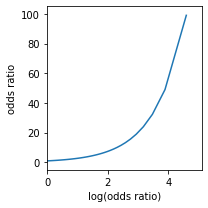

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(df['logit'], df['odds'])
ax.set_xlabel('log(odds ratio)')
ax.set_ylabel('odds ratio')
ax.set_xlim(0, 5.1)
ax.set_ylim(-5, 105)

plt.tight_layout()
plt.show()

## Assessing the Model
For comparison, here the GLM model using _statsmodels_. This method requires that the outcome is mapped to numbers. 

In [ ]:
# use GLM (general linear model) with the binomial family to 
# fit a logistic regression
y_numbers = [1 if yi == 'default' else 0 for yi in y]
logit_reg_sm = sm.GLM(y_numbers, X.assign(const=1), 
                      family=sm.families.Binomial())
logit_result = logit_reg_sm.fit()
print(logit_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                45342
Model:                            GLM   Df Residuals:                    45330
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28757.
Date:                Wed, 18 May 2022   Deviance:                       57515.
Time:                        05:44:08   Pearson chi2:                 4.54e+04
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
payment_inc_ratio      0.0797      0

Use splines

In [ ]:
import statsmodels.formula.api as smf
formula = ('outcome ~ bs(payment_inc_ratio, df=8) + purpose_ + ' +
           'home_ + emp_len_ + bs(borrower_score, df=3)')
model = smf.glm(formula=formula, data=loan_data, family=sm.families.Binomial())
results = model.fit()
print(results.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['outcome[default]', 'outcome[paid off]']   No. Observations:                45342
Model:                                                   GLM   Df Residuals:                    45321
Model Family:                                       Binomial   Df Model:                           20
Link Function:                                         logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -28731.
Date:                                       Wed, 18 May 2022   Deviance:                       57462.
Time:                                               05:44:09   Pearson chi2:                 4.54e+04
No. Iterations:                                            6                                         
Covariance Type:                                   nonrobust                      

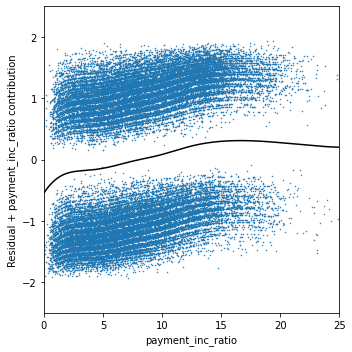

In [ ]:
from statsmodels.genmod.generalized_linear_model import GLMResults
def partialResidualPlot(model, df, outcome, feature, fig, ax):
    y_actual = [0 if s == 'default' else 1 for s in df[outcome]]
    y_pred = model.predict(df)
    org_params = model.params.copy()
    zero_params = model.params.copy()
    # set model parametes of other features to 0
    for i, name in enumerate(zero_params.index):
        if feature in name:
            continue
        zero_params[i] = 0.0
    model.initialize(model.model, zero_params)
    feature_prediction = model.predict(df)
    ypartial = -np.log(1/feature_prediction - 1)
    ypartial = ypartial - np.mean(ypartial)
    model.initialize(model.model, org_params)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': -2 * (y_actual - y_pred),
        'ypartial': ypartial/ 2,
    })
    results = results.sort_values(by=['feature'])

    ax.scatter(results.feature, results.residual, marker=".", s=72./fig.dpi)
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(results, loan_data, 'outcome', 'payment_inc_ratio', fig, ax)
ax.set_xlim(0, 25)
ax.set_ylim(-2.5, 2.5)


plt.tight_layout()
plt.show()

# Evaluating Classification Models
## Confusion Matrix

In [ ]:
# Confusion matrix
pred = logit_reg.predict(X)
pred_y = logit_reg.predict(X) == 'default'
true_y = y == 'default'
true_pos = true_y & pred_y
true_neg = ~true_y & ~pred_y
false_pos = ~true_y & pred_y
false_neg = true_y & ~pred_y

conf_mat = pd.DataFrame([[np.sum(true_pos), np.sum(false_neg)], [np.sum(false_pos), np.sum(true_neg)]],
                       index=['Y = default', 'Y = paid off'],
                       columns=['Yhat = default', 'Yhat = paid off'])
print(conf_mat)

              Yhat = default  Yhat = paid off
Y = default            14336             8335
Y = paid off            8148            14523


In [ ]:
print(confusion_matrix(y, logit_reg.predict(X)))

[[14336  8335]
 [ 8148 14523]]


The package _dmba_ contains the function `classificationSummary` that prints confusion matrix and accuracy for a classification model. 

In [ ]:
classificationSummary(y, logit_reg.predict(X), 
                      class_names=logit_reg.classes_)

Confusion Matrix (Accuracy 0.6365)

         Prediction
  Actual  default paid off
 default    14336     8335
paid off     8148    14523


## Precision, Recall, and Specificity
The _scikit-learn_ function `precision_recall_fscore_support` returns
precision, recall, fbeta_score and support. 

In [ ]:
conf_mat = confusion_matrix(y, logit_reg.predict(X))
print('Precision', conf_mat[0, 0] / sum(conf_mat[:, 0]))
print('Recall', conf_mat[0, 0] / sum(conf_mat[0, :]))
print('Specificity', conf_mat[1, 1] / sum(conf_mat[1, :]))

Precision 0.6376089663760897
Recall 0.6323496978518812
Specificity 0.6405981209474659


In [ ]:
precision_recall_fscore_support(y, logit_reg.predict(X), 
                                labels=['default', 'paid off'])

(array([0.63760897, 0.63535742]),
 array([0.6323497 , 0.64059812]),
 array([0.63496844, 0.63796701]),
 array([22671, 22671]))

## ROC Curve
The function `roc_curve` in _Scikit-learn_ calculates all the information that is required for plotting a ROC curve.

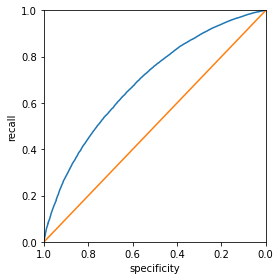

In [ ]:
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:, 0], 
                                 pos_label='default')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')


plt.tight_layout()
plt.show()

## AUC
Accuracy can easily be calculated using the _scikit-learn_ function `accuracy_score`.

In [ ]:
print(np.sum(roc_df.recall[:-1] * np.diff(1 - roc_df.specificity)))
print(roc_auc_score([1 if yi == 'default' else 0 for yi in y], logit_reg.predict_proba(X)[:, 0]))

0.691710795288669
0.6917108731135808


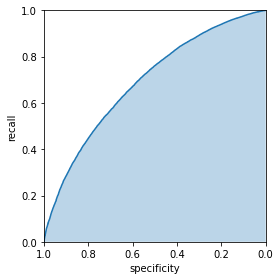

In [ ]:
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:,0], 
                                 pos_label='default')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
# ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')
ax.fill_between(roc_df.specificity, 0, roc_df.recall, alpha=0.3)


plt.tight_layout()
plt.show()

# Strategies for Imbalanced Data
## Undersampling
> The results differ from the R version, however are equivalent to results obtained using the R code. Model based results are of similar magnitude.

In [ ]:
full_train_set = pd.read_csv(FULL_TRAIN_SET_CSV)
print(full_train_set.shape)

(119987, 19)


In [ ]:
print('percentage of loans in default: ',
      100 * np.mean(full_train_set.outcome == 'default'))

percentage of loans in default:  18.894546909248504


In [ ]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 
              'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'
X = pd.get_dummies(full_train_set[predictors], prefix='', prefix_sep='', 
                   drop_first=True)
y = full_train_set[outcome]

full_model = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
full_model.fit(X, y)
print('percentage of loans predicted to default: ',
      100 * np.mean(full_model.predict(X) == 'default'))

percentage of loans predicted to default:  0.9759390600648404


In [ ]:
(np.mean(full_train_set.outcome == 'default') / 
 np.mean(full_model.predict(X) == 'default'))

19.360375747224595

## Oversampling and Up/Down Weighting

In [ ]:
default_wt = 1 / np.mean(full_train_set.outcome == 'default')
wt = [default_wt if outcome == 'default' else 1 for outcome in full_train_set.outcome]

full_model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_model.fit(X, y, wt)
print('percentage of loans predicted to default (weighting): ', 
      100 * np.mean(full_model.predict(X) == 'default'))

percentage of loans predicted to default (weighting):  61.79836148916132


## Data Generation
The package _imbalanced-learn_ provides an implementation of the _SMOTE_ and similar algorithms. 

In [ ]:
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print('percentage of loans in default (SMOTE resampled): ', 
      100 * np.mean(y_resampled == 'default'))

full_model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_model.fit(X_resampled, y_resampled)
print('percentage of loans predicted to default (SMOTE): ', 
      100 * np.mean(full_model.predict(X) == 'default'))


X_resampled, y_resampled = ADASYN().fit_resample(X, y)
print('percentage of loans in default (ADASYN resampled): ', 
      100 * np.mean(y_resampled == 'default'))

full_model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_model.fit(X_resampled, y_resampled)
print('percentage of loans predicted to default (ADASYN): ', 
      100 * np.mean(full_model.predict(X) == 'default'))

percentage of loans in default (SMOTE resampled):  50.0
percentage of loans predicted to default (SMOTE):  29.208164217790262
percentage of loans in default (ADASYN resampled):  48.56040383751355
percentage of loans predicted to default (ADASYN):  27.366298015618355


## Exploring the Predictions

In [ ]:
loan3000 = pd.read_csv(LOAN3000_CSV)

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy', 
                                   min_impurity_decrease=0.003)
loan_tree.fit(X, y)

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)

logit_reg = LogisticRegression(penalty="l2", solver='liblinear')
logit_reg.fit(X, y)


## model
gam = LinearGAM(s(0) + s(1))
print(gam.gridsearch(X.values, [1 if yi == 'default' else 0 for yi in y]))

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + intercept, 
   tol=0.0001, verbose=False)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


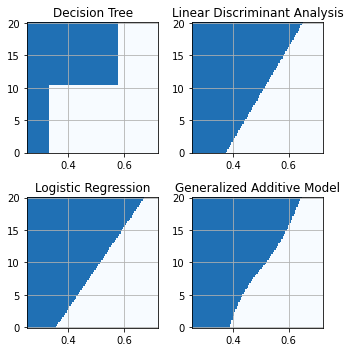

In [ ]:
models = {
    'Decision Tree': loan_tree,
    'Linear Discriminant Analysis': loan_lda,
    'Logistic Regression': logit_reg,
    'Generalized Additive Model': gam,
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))

xvalues = np.arange(0.25, 0.73, 0.005)
yvalues = np.arange(-0.1, 20.1, 0.1)
xx, yy = np.meshgrid(xvalues, yvalues)
X = np.c_[xx.ravel(), yy.ravel()]

boundary = {}

for n, (title, model) in enumerate(models.items()):
    ax = axes[n // 2, n % 2]
    predict = model.predict(X)
    if 'Generalized' in title:
        Z = np.array([1 if z > 0.5 else 0 for z in predict])
    else:
        
        Z = np.array([1 if z == 'default' else 0 for z in predict])
    Z = Z.reshape(xx.shape)
    boundary[title] = yvalues[np.argmax(Z > 0, axis=0)]
    boundary[title][Z[-1,:] == 0] = yvalues[-1]

    c = ax.pcolormesh(xx, yy, Z, cmap='Blues', vmin=0.1, vmax=1.3, shading='auto')
    ax.set_title(title)
    ax.grid(True)

plt.tight_layout()
plt.show()

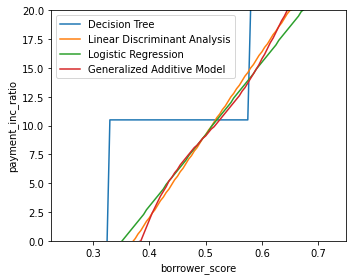

In [ ]:
boundary['borrower_score'] = xvalues
boundaries = pd.DataFrame(boundary)

fig, ax = plt.subplots(figsize=(5, 4))
boundaries.plot(x='borrower_score', ax=ax)
ax.set_ylabel('payment_inc_ratio')
ax.set_ylim(0, 20)


plt.tight_layout()
plt.show()